<a href="https://colab.research.google.com/github/42bismuth/Alzheimer-Detection/blob/main/nlp/Grid_search_(SVM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import pandas as pd
import spacy
import glob
import re
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
import pickle
import sys
from matplotlib import pyplot as plt

In [14]:
df = pd.read_csv('/content/cookie_tagged.csv', sep = ';')
df.head()

,label,sentence,text,pos_text,pos_,pos_text_complete,pos_complete,new_text,text_for_POS
0,0,"[""the boy is on a stool that is falling while ...",the boy is on a stool that is falling while he...,the DET boy NOUN is AUX on ADP a DET stool NOU...,DET NOUN AUX ADP DET NOUN PRON AUX VERB SCONJ ...,the determiner boy noun is auxiliary on adposi...,determiner noun auxiliary adposition determine...,the boy is on a stool that is falling while he...,the boy is on a stool that is falling while he...
1,0,"['oh I remember this one . [+ exc] ', 'okay . ...",oh I remember this one . [+ exc] okay . [+ ex...,oh INTJ I PRON remember VERB this DET one NOUN...,INTJ PRON VERB DET NOUN PUNCT X CCONJ X X SPAC...,oh interjection I pronoun remember verb this d...,interjection pronoun verb determiner noun punc...,oh I remember this one . okay . the mom's ...,oh I remember this one . okay . the mom's ...
2,1,"['the sink is running over . ', ""and &-uh the ...",the sink is running over . and &-uh the [/] t...,the DET sink NOUN is AUX running VERB over ADV...,DET NOUN AUX VERB ADV PUNCT SPACE CCONJ CCONJ ...,the determiner sink noun is auxiliary running ...,determiner noun auxiliary verb adverb punctuat...,the sink is running over . and -uh the [ repe...,the sink is running over . and -uh the the l...
3,0,"['the woman is wiping the dishes . ', ""she's s...",the woman is wiping the dishes . she's standi...,the DET woman NOUN is AUX wiping VERB the DET ...,DET NOUN AUX VERB DET NOUN PUNCT SPACE PRON AU...,the determiner woman noun is auxiliary wiping ...,determiner noun auxiliary verb determiner noun...,the woman is wiping the dishes . she's standi...,the woman is wiping the dishes . she's standi...
4,1,['&-uh a boy is &-uh puttin(g) somethin(g) in ...,&-uh a boy is &-uh puttin(g) somethin(g) in th...,& CCONJ -uh INTJ a DET boy NOUN is AUX & CCONJ...,CCONJ INTJ DET NOUN AUX CCONJ PROPN PROPN PUNC...,& Cconjunction -uh interjection a determiner b...,Cconjunction interjection determiner noun auxi...,-uh a boy is -uh puttin [ incomplete_word ] so...,-uh a boy is -uh puttin somethin in the clos...


In [4]:
X = df['pos_text_complete']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
pipeline = Pipeline(steps=[('vect', CountVectorizer()),
                           ('cls', SVC()),
                    ])

parameters = {
              'cls__C':  (0.001, 0.01, 1, 10),
              'cls__kernel':  ['linear', 'poly', 'rbf'],
              'cls__degree' : (2,3,4),
              'cls__gamma' : [0.0001,0.001,0.01,0.1,1]
              }

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=parameters,
                           scoring='roc_auc',
                           verbose=3,
                           n_jobs = -1,
                           cv=10
                          )


grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 180 candidates, totalling 1800 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('cls', SVC())]),
             n_jobs=-1,
             param_grid={'cls__C': (0.001, 0.01, 1, 10),
                         'cls__degree': (2, 3, 4),
                         'cls__gamma': [0.0001, 0.001, 0.01, 0.1, 1],
                         'cls__kernel': ['linear', 'poly', 'rbf']},
             scoring='roc_auc', verbose=3)

In [6]:
grid_search.best_params_

{'cls__C': 0.01,
 'cls__degree': 2,
 'cls__gamma': 0.0001,
 'cls__kernel': 'linear'}

In [7]:
best_svm = grid_search.best_estimator_

In [8]:
# Form a prediction set
predictions = best_svm.predict(X_test)

# Report the confusion matrix
confusion_matrix_model =(metrics.confusion_matrix(y_test,predictions))
target = ['Control', 'Dementia']

confusion_matrix_df = pd.DataFrame(confusion_matrix_model, index=target, columns=target)

confusion_matrix_df.columns.name = "Predicted"
confusion_matrix_df.index.name = "Real"

confusion_matrix_df

Predicted,Control,Dementia
Real,,
Control,38,13
Dementia,8,51


In [9]:
# Print a classification report
print(metrics.classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.83      0.75      0.78        51
           1       0.80      0.86      0.83        59

    accuracy                           0.81       110
   macro avg       0.81      0.80      0.81       110
weighted avg       0.81      0.81      0.81       110



In [13]:
pickle.dump(best_svm, open('best_svm.sav','wb') )

In [30]:
from sklearn.metrics import roc_curve , roc_auc_score
y_probas = best_svm.predict_proba(X_test)[:,1]
#skplt.metrics.plot_roc_curve(y_test, y_probas)
fpr, tpr, thresholds = roc_curve(y_test, y_probas)
#roc_auc = roc_auc_score(y_test, scores)
plt.plot(fpr, tpr)

plt.title("ROC Curve")

plt.xlabel("False Positive Rate")

plt.ylabel("True Positive Rate")

plt.show()

AttributeError: predict_proba is not available when  probability=False

## Use plain text for App model


In [15]:
X = df['text_for_POS']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
pipeline = Pipeline(steps=[('vect', CountVectorizer()),
                           ('cls', SVC())])



parameters = {
              'cls__C': [0.01],
              'cls__kernel': ['linear'],
              'cls__probability' : [True],
              'cls__class_weight' : ['balanced']
             }



grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=parameters,
                           scoring='roc_auc',
                           verbose=3,
                           n_jobs = -1,
                           cv=10
                          )



grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('cls', SVC())]),
             n_jobs=-1,
             param_grid={'cls__C': [0.01], 'cls__class_weight': ['balanced'],
                         'cls__kernel': ['linear'],
                         'cls__probability': [True]},
             scoring='roc_auc', verbose=3)

In [17]:
best_svm_app = grid_search.best_estimator_

In [18]:
# Form a prediction set
predictions = best_svm_app.predict(X_test)

# Report the confusion matrix
confusion_matrix_model =(metrics.confusion_matrix(y_test,predictions))
target = ['Control', 'Dementia']

confusion_matrix_df = pd.DataFrame(confusion_matrix_model, index=target, columns=target)

confusion_matrix_df.columns.name = "Predicted"
confusion_matrix_df.index.name = "Real"

confusion_matrix_df

Predicted,Control,Dementia
Real,,
Control,41,10
Dementia,10,49


In [19]:
# Print a classification report
print(metrics.classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80        51
           1       0.83      0.83      0.83        59

    accuracy                           0.82       110
   macro avg       0.82      0.82      0.82       110
weighted avg       0.82      0.82      0.82       110



In [22]:
pickle.dump(best_svm_app, open('best_svm_app.sav','wb') )

In [26]:
loaded_model = pickle.load(open('best_svm_app.sav', 'rb'))
loaded_model

Pipeline(steps=[('vect', CountVectorizer()),
                ('cls',
                 SVC(C=0.01, class_weight='balanced', kernel='linear',
                     probability=True))])

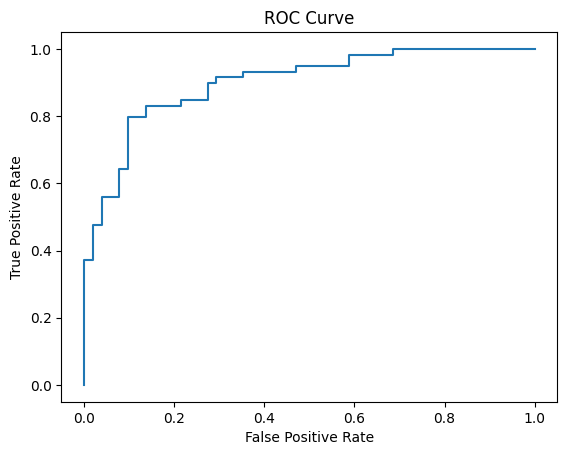

In [29]:
from sklearn.metrics import roc_curve , roc_auc_score
y_probas = best_svm_app.predict_proba(X_test)[:,1]
#skplt.metrics.plot_roc_curve(y_test, y_probas)
fpr, tpr, thresholds = roc_curve(y_test, y_probas)
#roc_auc = roc_auc_score(y_test, scores)
plt.plot(fpr, tpr)

plt.title("ROC Curve")

plt.xlabel("False Positive Rate")

plt.ylabel("True Positive Rate")

plt.show()
